# Social Media Use and its Impact on Human Emotion
### Final Project for DTSA 5509: Introduction to Machine Learning (Supervised Learning)

**By:** Andrea Francu  
**Version:** 2.0  
**Date:** December 23, 2024

This project explores the relationship between social media usage metrics and user mood prediction. It employs a variety of machine learning models, including **logistic regression**, **lasso and ridge regression**, and **random forest classifier**, to identify the most effective approach for accurately predicting a user's mood.
____
## Dependencies

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

____
## Dataset Overview
The dataset used for this project is sourced from Kaggle and titled "Social Media Usage and Emotional Well-Being." 

This dataset can be found here: https://www.kaggle.com/datasets/emirhanai/social-media-usage-and-emotional-well-being/data?select=val.csv

This dataset contains 10 features (descriptions are paraphrased from the Kaggle description):
- **User_ID**: User's unique identifier
- **Age**: User's age
- **Gender**: User's gender (Female, Male, Non-binary)
- **Platform**: Social media platform used
- **Daily_Usage_Time (minutes)**: Daily social media usage of the user on the platform
- **Posts_Per_Day**: Number of posts made by the user per day
- **Likes_Received_Per_Day**: Number of likes the user receives per day
- **Comments_Receiver_Per_Day**: Number of comments the user receives per day
- **Messages_Sent_Per_Day**: Number of messages the user sends per day
- **Dominant_Emotion**: User's dominant emotion during the day

`Dominant_Emotion` is the target variable for this project, and the goal is to find the most significant predictors of this feature and build a model that accurately predicts this emotion based on those features.

In [5]:
# load in the data files
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
val = pd.read_csv("val.csv", on_bad_lines = 'skip') # bypasses error thrown due to an extra entry by removing the row

Note: This dataset comes with 3 files: test, train, and val; however, combining these files into one and then splitting the data can help reduce any bias, as the method for how this data was split is not stated in the description.

In [6]:
data = pd.concat([train, test, val], ignore_index = True) # combine all data files, to be split later
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     1249 non-null   object 
 1   Age                         1249 non-null   object 
 2   Gender                      1248 non-null   object 
 3   Platform                    1248 non-null   object 
 4   Daily_Usage_Time (minutes)  1248 non-null   float64
 5   Posts_Per_Day               1248 non-null   float64
 6   Likes_Received_Per_Day      1248 non-null   float64
 7   Comments_Received_Per_Day   1248 non-null   float64
 8   Messages_Sent_Per_Day       1248 non-null   object 
 9   Dominant_Emotion            1247 non-null   object 
dtypes: float64(4), object(6)
memory usage: 97.7+ KB


,User_ID,Age,Gender,Platform,Daily_Usage_Time (minutes),Posts_Per_Day,Likes_Received_Per_Day,Comments_Received_Per_Day,Messages_Sent_Per_Day,Dominant_Emotion
0,1,25,Female,Instagram,120.0,3.0,45.0,10.0,12.0,Happiness
1,2,30,Male,Twitter,90.0,5.0,20.0,25.0,30.0,Anger
2,3,22,Non-binary,Facebook,60.0,2.0,15.0,5.0,20.0,Neutral
3,4,28,Female,Instagram,200.0,8.0,100.0,30.0,50.0,Anxiety
4,5,33,Male,LinkedIn,45.0,1.0,5.0,2.0,10.0,Boredom


Now that the data is combined, we can take a look at some of the features and their characteristics.

**Data Size**: The data has 1249 entries, with 10 columns (parameters)

**Data Types**: `User_ID`, `Age`, `Gender`, `Platform`, `Messages_Sent_Per_Day`, and `Dominant_Emotion` are all objects, whereas `Daily_Usage_Tim (minutes)`, `Posts_Per_Day`, `Likes_Received_Per_Day`, and `Comments_Receiver_Per_Day` are float64 by default. Some of these data types need to be modified, as features like `Age` and `Messages_Sent_Per_Day` are numeric and should be treated as such.
___

## Data Cleaning - Numeric Features
This section was carried out *iteratively*, with certain data cleaning steps occurring after the initial models were built. Insights gained from the early models revealed additional actions needed to further clean and organize the data.

In [8]:
# drop User_ID column, as it doesn't add any meaningful insight as a predictor
data.drop(['User_ID'], axis = 1, inplace = True)
data.nunique()

Age                           19
Gender                        20
Platform                       8
Daily_Usage_Time (minutes)    34
Posts_Per_Day                 10
Likes_Received_Per_Day        55
Comments_Received_Per_Day     31
Messages_Sent_Per_Day         59
Dominant_Emotion               7
dtype: int64

To get a better idea of whats in each feature, nunique() can be used to see how many unique values are listed for each category. This summary indicates there may be something wrong with the gender category, since the Kaggle page stated 3 options for this category but there are 20 unique entries. A value count of the entries in this can give more insight into the issue:

In [9]:
data['Gender'].value_counts()

Gender
Female        415
Male          411
Non-binary    331
29             10
28             10
24              9
27              9
31              8
22              8
33              6
25              6
34              6
26              5
21              4
30              2
23              2
35              2
32              2
Marie           1
Facebook        1
Name: count, dtype: int64

It looks like some of the entries got set in the wrong column. It looks like these got mixed up mostly with the age column, which is right next to the `Gender` one. This can be confirmed by checking the value counts of the age column.

In [10]:
data['Age'].value_counts()

Age
28                                                      120
27                                                      116
29                                                      111
26                                                       88
22                                                       86
24                                                       84
31                                                       82
25                                                       79
21                                                       69
23                                                       68
33                                                       67
30                                                       51
32                                                       47
35                                                       46
34                                                       44
Female                                                   34
Male                                

A simple resolution for this issue is to swap age and gender anywhere that age is set to a value that should be in the gender category.

In [12]:
gender_age = data[(data['Age'] == 'Female') | (data['Age'] == 'Male') | (data['Age'] == 'Non-binary')] #  find the indices where data is swapped
data.loc[gender_age.index, ['Age', 'Gender']] = data.loc[gender_age.index, ['Gender', 'Age']].values # swap the values back to their correct location
data['Gender'].value_counts() # check unique values in Gender again

Gender
Female        449
Male          444
Non-binary    354
Marie           1
Name: count, dtype: int64

In [14]:
data = data[data['Gender'] != 'Marie'] # remove the one incorrect entry
data['Age'].value_counts() # check unique values in Age again

Age
28                                                      130
27                                                      125
29                                                      121
22                                                       94
24                                                       93
26                                                       93
31                                                       90
25                                                       85
21                                                       73
33                                                       73
23                                                       70
30                                                       53
34                                                       50
35                                                       48
32                                                       48
 işte mevcut veri kümesini 1000 satıra tamamlıyorum:      1
Facebook                            

The `Gender` column looks ok now, but the `Age` column needs some further error fixing. `Age` has 2 inputs that should not be there, but this can be fixed by simply converting all the categories that should be numeric but aren't to numeric. By setting the `to_numeric` parameter 'errors' to 'coerce', this converts any non number to a NaN, which can later be removed.

In [15]:
data['Age'] = pd.to_numeric(data['Age'], errors = 'coerce') # convert Age entries to numeric
data['Messages_Sent_Per_Day'] = pd.to_numeric(data['Messages_Sent_Per_Day'], errors = 'coerce') # convert Messages_Sent_Per_Day to numeric

In [ ]:
data['Platform'].value_counts() # check unique values in Platform

Platform
Instagram    302
Facebook     247
Twitter      244
LinkedIn     154
Snapchat     112
Telegram      98
Whatsapp      89
55             1
Name: count, dtype: int64

In [18]:
data = data[data['Platform'] != '55'] # remove the one incorrect entry
data['Dominant_Emotion'].value_counts() # check unique values in Dominant_Emotion

Dominant_Emotion
Neutral      257
Happiness    241
Anxiety      223
Sadness      199
Boredom      174
Anger        151
Agression      1
Name: count, dtype: int64

In [19]:
data = data[data['Dominant_Emotion'] != 'Agression'] # remove this category as it only has one entry
data = data.rename(columns = {'Daily_Usage_Time (minutes)': 'Daily_Usage_Time'}) # rename for simplicity
data.isna().sum() # check for NA entries

Age                          1
Gender                       1
Platform                     1
Daily_Usage_Time             1
Posts_Per_Day                1
Likes_Received_Per_Day       1
Comments_Received_Per_Day    1
Messages_Sent_Per_Day        1
Dominant_Emotion             1
dtype: int64

In [20]:
data = data.dropna() # remove NA entries
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1245 entries, 0 to 1248
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        1245 non-null   float64
 1   Gender                     1245 non-null   object 
 2   Platform                   1245 non-null   object 
 3   Daily_Usage_Time           1245 non-null   float64
 4   Posts_Per_Day              1245 non-null   float64
 5   Likes_Received_Per_Day     1245 non-null   float64
 6   Comments_Received_Per_Day  1245 non-null   float64
 7   Messages_Sent_Per_Day      1245 non-null   float64
 8   Dominant_Emotion           1245 non-null   object 
dtypes: float64(6), object(3)
memory usage: 97.3+ KB


The data is now cleaned and corrected, with NA's removed. Any swapped data has either been swapped back or removed, and all categories are set to the correct data type. Up next is taking a look at which features are most significant, seeing if there's any interaction between features, and visualizing these possible interactions. To get an idea of the relationship between predictors, a pair plot can give good insight into this.

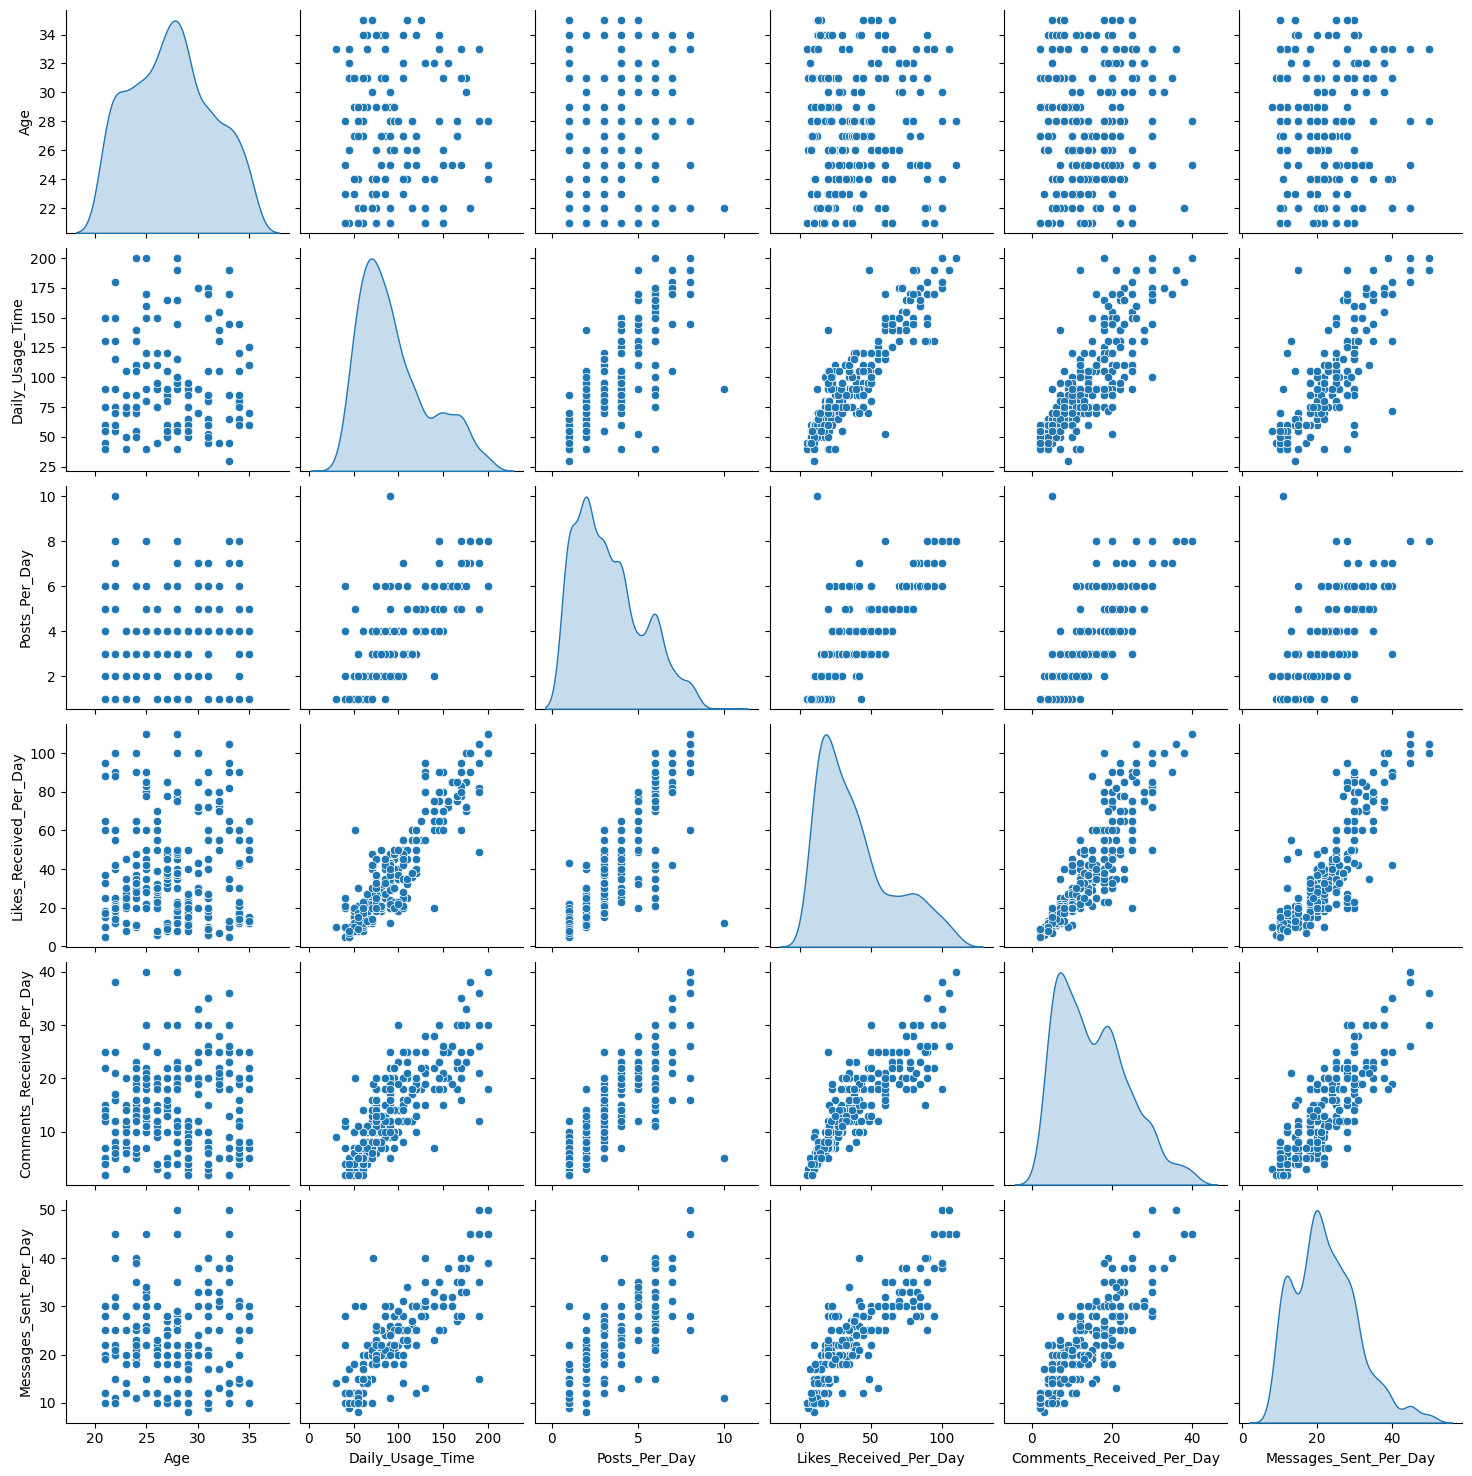

In [21]:
sns.pairplot(data, diag_kind = 'kde')

A few things to note from this pair plot: 
- `Age` does not seem to be related to any of the other numeric features.
- `Daily_Usage_Time`, `Posts_Per_Day`, `Likes_Received_Per_Day`, and `Comments_Received_Per_Day` all seem to be linearly positively related. This indicates that there may be some interaction between these features.

However, this only gives insight into interactions between numeric features. The next step is to handle the categorical variables.

___

## Data Cleaning - Categorical Variables


There are 2 features that fall into the category of **non-ordinal categorical variables**: gender and platform. This is because they are categories that don't have a meaninful order. One solution is to convert these categories into binary variables using **one-hot encoding**. First, new binary columns must be created for each option for these categories, which can be done with the pandas function get_dummies.

In [24]:
data['Platform'].value_counts() # get a look at the spread of responses for Platform

Platform
Instagram    301
Facebook     247
Twitter      244
LinkedIn     154
Snapchat     112
Telegram      98
Whatsapp      89
Name: count, dtype: int64

In [25]:
data = pd.get_dummies(data, columns = ['Gender']) # encode Gender responses as new features
data = pd.get_dummies(data, columns = ['Platform']) # encode Platform responses as new features
data = data.rename(columns = {'Gender_Non-binary': 'Gender_Non_binary'}) # replace special char
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1245 entries, 0 to 1248
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        1245 non-null   float64
 1   Daily_Usage_Time           1245 non-null   float64
 2   Posts_Per_Day              1245 non-null   float64
 3   Likes_Received_Per_Day     1245 non-null   float64
 4   Comments_Received_Per_Day  1245 non-null   float64
 5   Messages_Sent_Per_Day      1245 non-null   float64
 6   Dominant_Emotion           1245 non-null   object 
 7   Gender_Female              1245 non-null   bool   
 8   Gender_Male                1245 non-null   bool   
 9   Gender_Non_binary          1245 non-null   bool   
 10  Platform_Facebook          1245 non-null   bool   
 11  Platform_Instagram         1245 non-null   bool   
 12  Platform_LinkedIn          1245 non-null   bool   
 13  Platform_Snapchat          1245 non-null   bool   
 1

Now that all the data is numeric, a correlation matrix can help show relationships between predictors

In [26]:
correlation_matrix = data.drop(columns = ['Dominant_Emotion']).corr() # make correlation matrix of only predictors (response is categorical)
correlation_matrix

,Age,Daily_Usage_Time,Posts_Per_Day,Likes_Received_Per_Day,Comments_Received_Per_Day,Messages_Sent_Per_Day,Gender_Female,Gender_Male,Gender_Non_binary,Platform_Facebook,Platform_Instagram,Platform_LinkedIn,Platform_Snapchat,Platform_Telegram,Platform_Twitter,Platform_Whatsapp
Age,1.000000,0.093221,0.032007,0.068068,0.099465,0.104882,-0.038697,0.217168,-0.189592,-0.173497,0.103676,0.196076,-0.115643,0.057043,-0.088574,0.050971
Daily_Usage_Time,0.093221,1.000000,0.871729,0.932801,0.882833,0.896025,0.331066,-0.052422,-0.296831,-0.299914,0.831822,-0.371440,-0.026588,-0.133361,-0.143169,-0.053961
Posts_Per_Day,0.032007,0.871729,1.000000,0.903585,0.897549,0.854427,0.302008,-0.011457,-0.309425,-0.342113,0.736625,-0.386134,-0.093407,-0.084904,0.019666,-0.038994
Likes_Received_Per_Day,0.068068,0.932801,0.903585,1.000000,0.926594,0.903246,0.344662,-0.008286,-0.358216,-0.368165,0.846653,-0.373942,-0.097848,-0.103674,-0.075893,-0.025313
Comments_Received_Per_Day,0.099465,0.882833,0.897549,0.926594,1.000000,0.876754,0.294085,0.042962,-0.358822,-0.376501,0.713866,-0.417467,-0.072459,-0.082730,0.066871,-0.006171
Messages_Sent_Per_Day,0.104882,0.896025,0.854427,0.903246,0.876754,1.000000,0.272684,0.025724,-0.317712,-0.329690,0.725818,-0.422276,-0.012314,-0.024915,-0.071686,-0.006088
Gender_Female,-0.038697,0.331066,0.302008,0.344662,0.294085,0.272684,1.000000,-0.558194,-0.471644,-0.310039,0.319295,-0.042776,0.015780,-0.219150,-0.003376,0.220688
Gender_Male,0.217168,-0.052422,-0.011457,-0.008286,0.042962,0.025724,-0.558194,1.000000,-0.468360,-0.139124,-0.052263,0.051337,-0.234083,0.249388,0.194244,-0.063392
Gender_Non_binary,-0.189592,-0.296831,-0.309425,-0.358216,-0.358822,-0.317712,-0.471644,-0.468360,1.000000,0.478009,-0.284465,-0.009008,0.231971,-0.031674,-0.202841,-0.167633
Platform_Facebook,-0.173497,-0.299914,-0.342113,-0.368165,-0.376501,-0.329690,-0.310039,-0.139124,0.478009,1.000000,-0.280919,-0.186909,-0.156415,-0.145417,-0.245619,-0.138038


<Axes: >

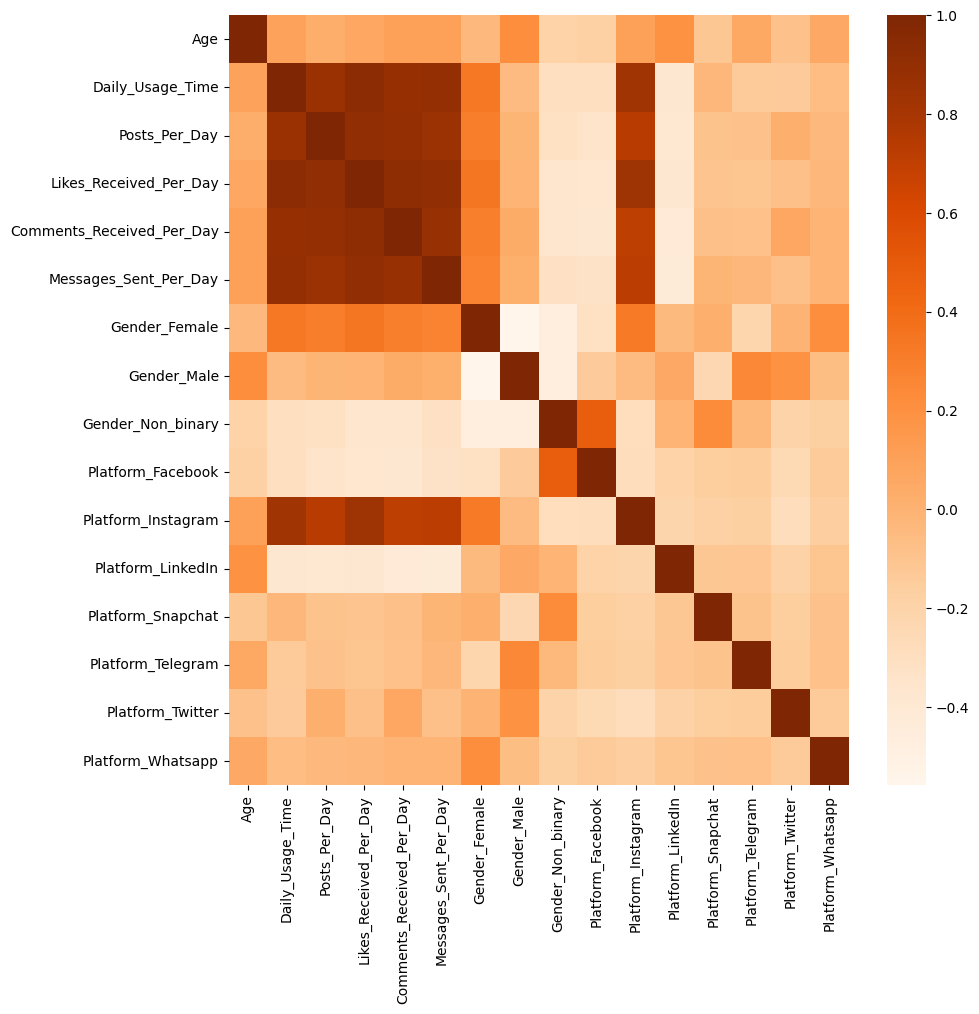

In [28]:
plt.figure(figsize = (10, 10)) # plot the correlation matrix as a heatmap for better visualization
sns.heatmap(correlation_matrix, cmap = "Oranges")

As we can see here, there are several features that are highly correlated with each other:
- `Daily_Usage_Time`
- `Posts_Per_Day`
- `Likes_Received_Per_Day`
- `Comments_Received_Per_Day`
- `Messages_Sent_Per_Day`
- `Platform_Instagram`

All of these features, except `Platform_Instagram`, are features related to how much someone uses social media. It would make sense that these are highly correlated as someone who receives many likes per day likely also receives many comments per day. `Platform_Instagram` is likely correlated with these as well because most of the data collected was with regards to Instagram, and some of the variables are not even features of other platforms. For example, there are no posts or comments in Telegram or Whatsapp, as these are messaging applications. 


___
## Handling Multicollinearity
Due to all these signs of multicollinearity, one path forward to avoid duplicate data is to combine some of these features. `Posts_Per_Day`, `Likes_Received_Per_Day`, `Comments_Received_Per_Day`, and `Messages_Sent_Per_Day` are all correlated as they all represent a person's activity levels on socail media. Since these all provide meaningful insight, rather than removing some features, they can be combined into one predictor, called `Total_Activity`. This way, the collinearity is reduced, but none of the data is removed. 

In [29]:
data['Total_Activity'] = (data['Posts_Per_Day'] + data['Likes_Received_Per_Day'] +
                              data['Comments_Received_Per_Day'] + data['Messages_Sent_Per_Day'])

data.drop(['Posts_Per_Day', 'Likes_Received_Per_Day', 
               'Comments_Received_Per_Day', 'Messages_Sent_Per_Day'], axis = 1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1245 entries, 0 to 1248
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 1245 non-null   float64
 1   Daily_Usage_Time    1245 non-null   float64
 2   Dominant_Emotion    1245 non-null   object 
 3   Gender_Female       1245 non-null   bool   
 4   Gender_Male         1245 non-null   bool   
 5   Gender_Non_binary   1245 non-null   bool   
 6   Platform_Facebook   1245 non-null   bool   
 7   Platform_Instagram  1245 non-null   bool   
 8   Platform_LinkedIn   1245 non-null   bool   
 9   Platform_Snapchat   1245 non-null   bool   
 10  Platform_Telegram   1245 non-null   bool   
 11  Platform_Twitter    1245 non-null   bool   
 12  Platform_Whatsapp   1245 non-null   bool   
 13  Total_Activity      1245 non-null   float64
dtypes: bool(10), float64(3), object(1)
memory usage: 60.8+ KB


____
## Response Variable
Now that all the predictors are cleaned and cast to variable types that machine learning methods can easily handle, let's take a look at the response variable. The variable we are trying to predict is `Dominant_Emotion`. This is a categorical variable, therefore the type of prediction we aim to do is **classification**. The goal is to find a model that can best predict our response.

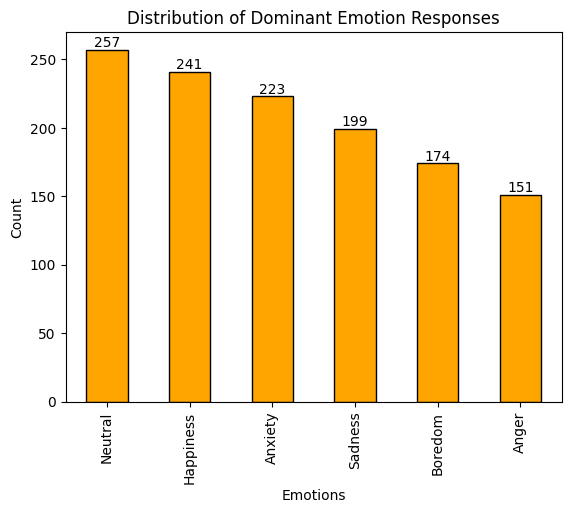

In [31]:
# visualize feature spread with bar plot
counts = data['Dominant_Emotion'].value_counts()
ax = counts.plot(kind = 'bar', color = 'orange', edgecolor = 'black', 
                                            title = 'Distribution of Dominant Emotion Responses', 
                                            xlabel = 'Emotions', ylabel = 'Count')

for i, value in enumerate(counts):
    ax.text(i, value, str(value), ha = 'center', va = 'bottom')

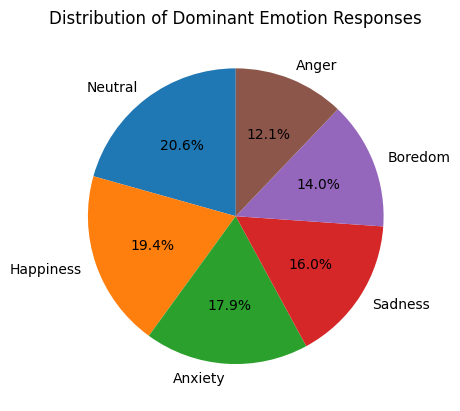

In [32]:
# visualize same data with pie chart
fig, ax = plt.subplots()
ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of Dominant Emotion Responses')
plt.show()

These plots shows that the distribution of emotions shows a bit of class imbalance, but nothing too extreme. This can be kept in mind when selecting a model. Some algorithms, like decision trees, all weight assignments to classes, to account for any imbalance. Another useful visualization we can use is a boxplot comparing `Total_Activity` to `Dominant_Emotion`.

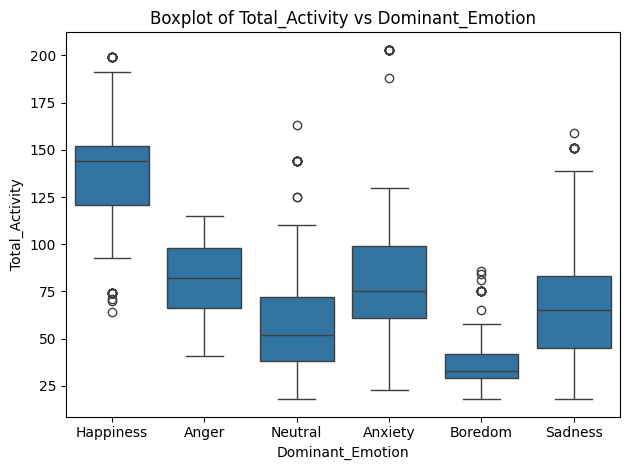

In [34]:
# create boxplot to see interaction between Total_Activity and response variable
sns.boxplot(x = 'Dominant_Emotion', y = 'Total_Activity', data = data)
plt.title(f'Boxplot of Total_Activity vs Dominant_Emotion')
plt.xlabel('Dominant_Emotion')
plt.ylabel('Total_Activity')

# Adjust the layout
plt.tight_layout()
plt.show()

It appears that a higher total activity is associated with happiness, slightly lower activity is linked to more negative emotions (anger, anxiety, sadness), and the least amount of activity is related to neutral feelings, like neutral and boredom. This is interesting to note, as it appears there is a "sweet spot" of activity that results in negative emotions, rather than a linear relationship between emotions and activity (i.e more activity leads to more positive or more negative emotion)
___

## Splitting the Data
Now that the features have been sorted to reduce interactions, and the categorical features have been encoded to all be numerical or binary in one of the data frames, it is time to split both our datasets into test and train to begin modeling. This uses a common 20% test and 80% train split.

In [35]:
X = data.drop(columns = ['Dominant_Emotion']) # create df of only the predictors
y = data['Dominant_Emotion'] # create df of only the response


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123) # split into train/test
predictors = X.columns # keep a list of the predictors

print(f"Train set shape: {X_train.shape}") # print out the dimensions of X_train
print(f"Test set shape: {X_test.shape}") # print out the dimensions of X_test

test = pd.concat([X_test, y_test], axis = 1) # make df for test data
train = pd.concat([X_train, y_train], axis = 1) # make df for train data

Train set shape: (996, 13)
Test set shape: (249, 13)


One final adjustment to the data is to normalize the predictors. Many algorithms, like logistic regression, perform better when normalized, to account for non-normal feature distributions. 

In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

___

## Modeling Time!
Now it's time to build the models. The different models tested here include **logistic regression**, **lasso and ridge regression**, and **random forest classifier**. Each algorithm comes with its own set of pros and cons, and by trying out multiple, we can see which is the best fit for this data.

| **Model** | **Pros** | **Cons**    |
|----------------------------|---------------------------------|---------------------------------------------|
| **Logistic Regression**   | - Simple and interpretable. <br> - Fast training. <br> - Works with linear data.                 | - Assumes linearity. <br> - Sensitive to outliers. <br> - Needs scaling.                         |
| **Lasso and Ridge Regression** | - Reduces overfitting. <br> - Lasso performs feature selection. <br> - Handles multicollinearity. | - Assumes linearity. <br> - Struggles with non-linear data. <br> - Doesn’t capture interactions. |
| **Random Forest Classifier** | - Handles non-linearity. <br> - Works with mixed data types. <br> - Robust to overfitting.     | - Computationally expensive. <br> - Less interpretable. <br> - Can overfit with too many trees. |

____
### Logistic Regression
The first model to try here is logistic regression, as this model is simple and quick to implement. However, this method, along with lasso and ridge regression, assume linearity, which our data may not necessarily have.

In [37]:
# fit a logistic regression model on scaled data
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)

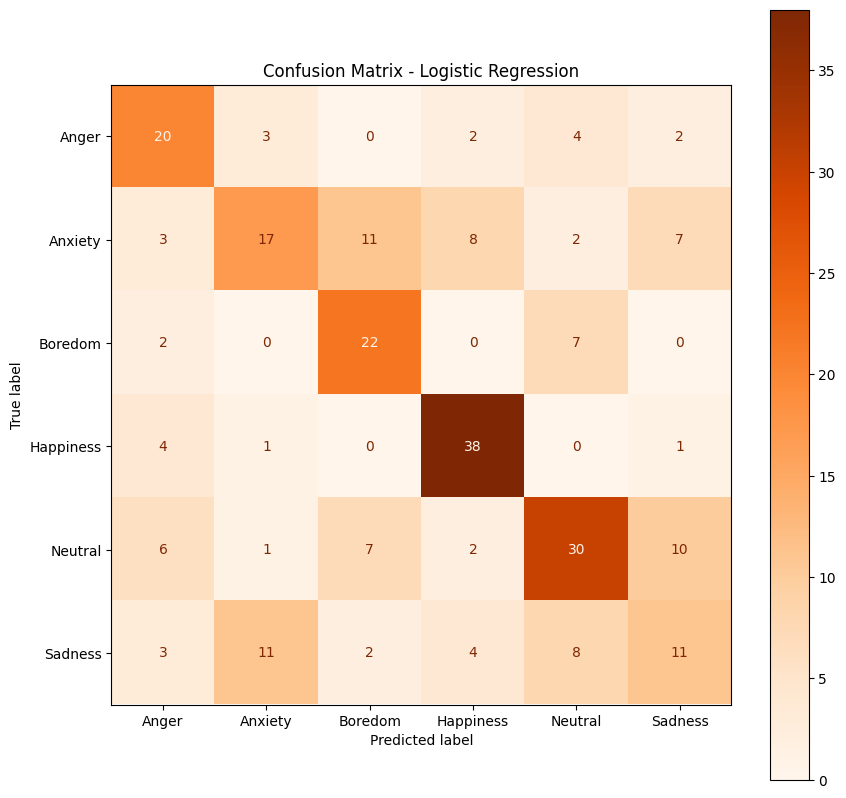

In [38]:
# save off performance metrics to be used to compare between models later
log_reg_accuracy = accuracy_score(y_test, y_pred_log_reg)
log_reg_precision = precision_score(y_test, y_pred_log_reg, average = 'weighted', zero_division = 0)
log_reg_recall = recall_score(y_test, y_pred_log_reg, average = 'weighted', zero_division = 0)
log_reg_f1 = f1_score(y_test, y_pred_log_reg, average = 'weighted', zero_division = 0)

# create and plot a confusion matrix of predicted vs. actual labels
class_labels = log_reg.classes_
cm = confusion_matrix(y_test, y_pred_log_reg)
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_labels)
disp.plot(cmap = 'Oranges')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

Looking at the confusion matrix for this model, it appears that many of the labels were accurately predicted; however, there are quite a few labels that were incorrectly predicted. Anxiety was the most common true label that was incorrectly classified as something else, and sadness was the most common predicted label that was incorrectly classified.
____
### Ridge and Lasso Regression

An advantage to using ridge and lasso methods, is that they weigh predictors by penalizing those that are not significant and boosting those that are. This may increase model performance, since not all the predictors are necessarily that significant.

#### Ridge Regression

In [39]:
# fit a ridge regression model on scaled data
ridge = LogisticRegression(penalty = 'l2', multi_class = 'multinomial', max_iter = 1000)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

/Users/apple/Desktop/github/social-sentiment/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


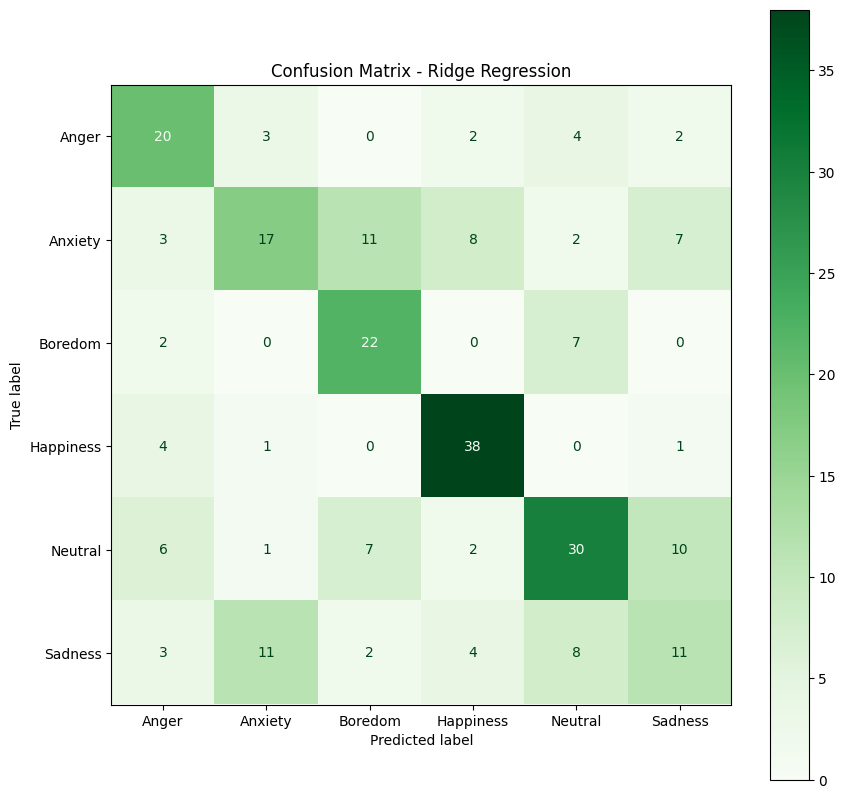

In [40]:
# save off performance metrics to be used to compare between models later
ridge_accuracy = accuracy_score(y_test, y_pred_ridge)
ridge_precision = precision_score(y_test, y_pred_ridge, average = 'weighted', zero_division = 0)
ridge_recall = recall_score(y_test, y_pred_ridge, average = 'weighted', zero_division = 0)
ridge_f1 = f1_score(y_test, y_pred_ridge, average = 'weighted', zero_division = 0)

# create and plot a confusion matrix of predicted vs. actual labels
class_labels = ridge.classes_
cm = confusion_matrix(y_test, y_pred_ridge)
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_labels)
disp.plot(cmap = 'Greens')
plt.title('Confusion Matrix - Ridge Regression')
plt.show()

This confusion matrix actually looks the exact same as the one for logistic regression, indicating that it gave the same labels to the same data points. This could indicate that maybe there is just not enough data to accurately predict emotion, since a different model ended up with the same result. 
### Lasso Regression

In [41]:
# fit a lasso regression model on scaled data
lasso = LogisticRegression(penalty = 'l1', solver = 'saga', multi_class = 'multinomial', max_iter = 1000)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)

/Users/apple/Desktop/github/social-sentiment/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


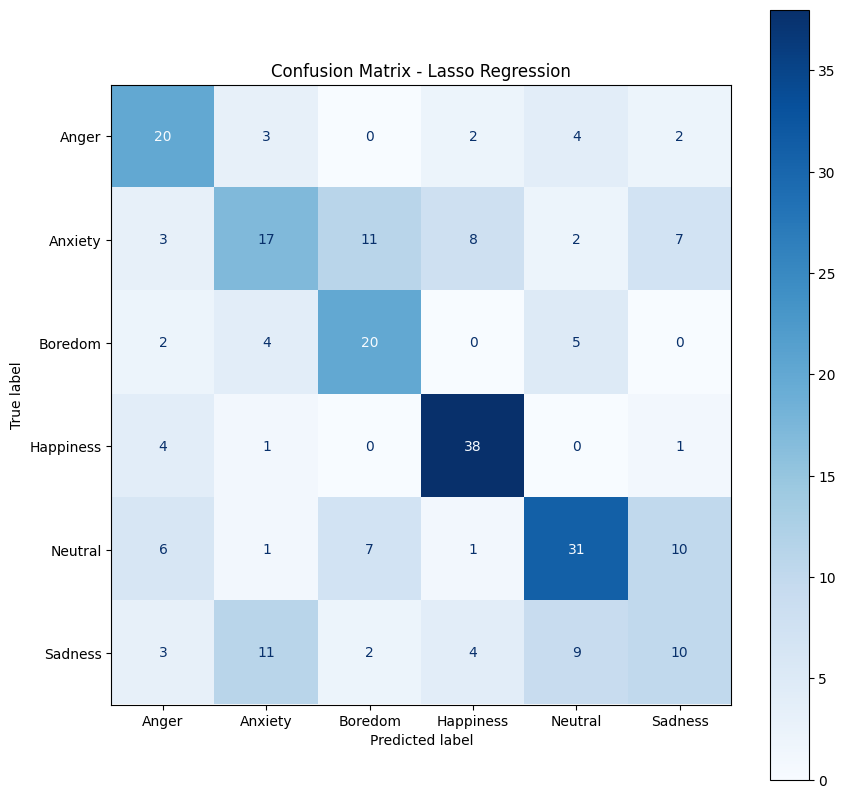

In [42]:
# save off performance metrics to be used to compare between models later
lasso_accuracy = accuracy_score(y_test, y_pred_lasso)
lasso_precision = precision_score(y_test, y_pred_lasso, average = 'weighted', zero_division = 0)
lasso_recall = recall_score(y_test, y_pred_lasso, average = 'weighted', zero_division = 0)
lasso_f1 = f1_score(y_test, y_pred_lasso, average = 'weighted', zero_division = 0)

# create and plot a confusion matrix of predicted vs. actual labels
class_labels = lasso.classes_
cm = confusion_matrix(y_test, y_pred_lasso)
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_labels)
disp.plot(cmap = 'Blues')
plt.title('Confusion Matrix - Lasso Regression')
plt.show()

Lasso regression results in a different confusion matrix, though the performance of the model doesn't seem much different. Anxiety is still the most inaccurately predicted true label, and sadness is still the most inaccurately classified predicted label.
____
### Random Forest Classifier
One final model to test out is the random forest classifier. The advantage of this model is that it often has high accuracy, since it combines multiple decisions trees. It also handles non-linear data well, which seems like might be a good fit for this data. It could be that our data is non-linear, so the models assuming linearity are not performing as well. We also have a small amount of data and a few of the models tried so far are sensitive to outliers. Random forest classifier is a robust and high performance model. Though it is computationally extensive, this doesn't matter too much here as we are working with a fairly small dataset.

In [43]:
# fit a random forest classifier on scaled data
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 123)
random_forest.fit(X_train, y_train)
y_pred_rfc = random_forest.predict(X_test)

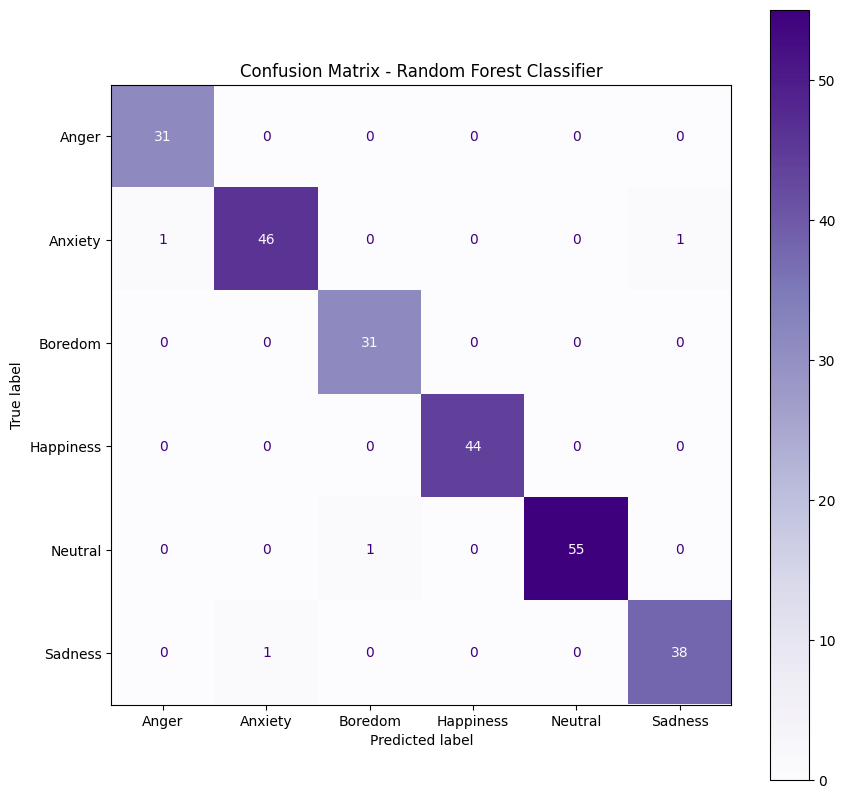

In [44]:
# save off performance metrics to be used to compare between models later
rfc_accuracy = accuracy_score(y_test, y_pred_rfc)
rfc_precision = precision_score(y_test, y_pred_rfc, average = 'weighted', zero_division = 0)
rfc_recall = recall_score(y_test, y_pred_rfc, average = 'weighted', zero_division = 0)
rfc_f1 = f1_score(y_test, y_pred_rfc, average = 'weighted', zero_division = 0)

# create and plot a confusion matrix of predicted vs. actual labels
cm = confusion_matrix(y_test, y_pred_rfc)
class_labels = random_forest.classes_
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_labels)
disp.plot(cmap = 'Purples')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()

This model clearly predicts the response much more accurately than any of the regression models. There are only a few times when this model predicted the response incorrectly, indicating a very good fit.

___
## Evaluating the Models
Now that multiple models have been created, various performance metrics can be used to choose the best model.

### Performance Metrics
There are various metrics that can be used to analyze how well a model predicted the correct classification. The ones I've collected here are: accuracy, precision, recall, and F1 score. 
- **Accuracy**: gives a general feel for model performance, but is sensitive to imbalanced datasets. From the bar graph of the emotion variable earlier, this data does show slight imbalance of classes.
- **Precision**: is most useful when trying to avoid false positives, because it looks at true positives. 
- **Recall**: is useful when trying to avoid false negatives, since it looks at all actual positive cases and how many are handles correctly.
- **F1 score**: balances precision and recall, which may be most beneficial to the goal of this project, since it doesn't lean too far either way when it comes to prioritizing true positives vs. true negatives.

In [45]:
ridge_lasso_rf_comparisons = {
    "Model": ["Logistic Regression", "Ridge Regression", "Lasso Regression", "Random Forest Classifier"], 
    "Accuracy": [log_reg_accuracy, ridge_accuracy, lasso_accuracy, rfc_accuracy],
    "Precision": [log_reg_precision, ridge_precision, lasso_precision, rfc_precision],
    "Recall": [log_reg_recall, ridge_recall, lasso_recall, rfc_recall],
    "F1 Score": [log_reg_f1, ridge_f1, lasso_f1, rfc_f1],
    
}

ridge_lasso_rf_comparisons_df = pd.DataFrame(ridge_lasso_rf_comparisons)
ridge_lasso_rf_comparisons_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.554217,0.542265,0.554217,0.540504
1,Ridge Regression,0.554217,0.542265,0.554217,0.540504
2,Lasso Regression,0.546185,0.531953,0.546185,0.533586
3,Random Forest Classifier,0.983936,0.984101,0.983936,0.983918


As expected, the random forest classifier far outperformed the other regression models, in all metrics. Logistic and ridge regression had the same values for all four metrics, around 55%, which makes sense since we saw identical confusion matrices for these two models. Lasso regression had very similar and slightly poorer performance metrics, around 54%. Random forest classifier has performance metric values of about 98% for all metrics, making it the clear winner.

___

## Discussion

### Model Selection - Random Forest Classifier
The Random Forest classifier significantly outperformed the other models, likely due to its robustness to collinearity, ability to handle non-linear data, and relatively low need for fine-tuning.

While **logistic regression**, **lasso**, and **ridge regression** each offer distinct advantages, they assume a linear relationship between predictors and the response, which may not align with the nature of this dataset. Despite its computational expense, **random forest** turned out to be an ideal fit for our small dataset.

In the future, exploring additional classification models such as Support Vector Machines (SVM) and K-Nearest Neighbors (KNN), which often yield performance comparable to Random Forest, would be a valuable next step.

Overall, supervised learning offers a multitude of approaches, and there are endless possibilities for experimentation. After dedicating significant time to the models I selected, I’m pleased to have identified one that predicts the data with 98% accuracy. This project has provided invaluable insights into model selection based on the data at hand, the importance of understanding available data types, and making informed decisions. In the initial version of this project, I had used linear regression, encoding the response variable; however, I later realized that a classification approach was more appropriate. This led me to replace linear regression with logistic regression. If I were to iterate further, I would explore SVM and KNN to assess their potential.